# Grocery Stroe Sales Analysis
## Objectives

Hi There, and thanks for your help. If you're reading this you've been selected to help on a secret initiative.

You will be helping us analyze a portion of data from a company we want to acquire, which could greatly improve the fortunes of Maven Mega Mart.

We'll be working with `project_transactions.csv` and briefly take a look at `product.csv`.

First, read in the transactions data and explore it.

* Take a look at the raw data, the datatypes, and cast `day`, `quantity`, `store_id`, and `week_no` columns to the smallest appropriate datatype. Check the memory reduction by doing so.
* Is there any missing data?
* How many unique households and products are there in the data? The fields household_key and product_id will help here.

In [1]:
import pandas as pd
import numpy as np

In [6]:
transactions =  pd.read_parquet('../project-data/grocery-data.parquet')

In [7]:
transactions.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,1364,26984896261,1,842930,1,2.19,31742,0.00,1,0.0,0.0
1,1364,26984896261,1,897044,1,2.99,31742,-0.40,1,0.0,0.0
2,1364,26984896261,1,920955,1,3.09,31742,0.00,1,0.0,0.0
3,1364,26984896261,1,937406,1,2.50,31742,-0.99,1,0.0,0.0
4,1364,26984896261,1,981760,1,0.60,31742,-0.79,1,0.0,0.0


In [8]:
transactions.columns = [col.lower() for col in transactions.columns]

In [9]:
transactions.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146311 entries, 0 to 2146310
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   household_key      int64  
 1   basket_id          int64  
 2   day                int64  
 3   product_id         int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   week_no            int64  
 9   coupon_disc        float64
 10  coupon_match_disc  float64
dtypes: float64(4), int64(7)
memory usage: 180.1 MB


In [111]:
transactions.describe().round()

,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,week_no,coupon_disc,coupon_match_disc
count,2146311.0,2.146311e+06,2146311.0,2146311.0,2146311.0,2146311.0,2146311.0,2146311.0,2146311.0,2146311.0,2146311.0
mean,1056.0,3.404897e+10,390.0,2884715.0,101.0,3.0,3268.0,-1.0,56.0,-0.0,-0.0
std,605.0,4.723748e+09,190.0,3831949.0,1152.0,4.0,9122.0,1.0,27.0,0.0,0.0
min,1.0,2.698490e+10,1.0,25671.0,0.0,0.0,1.0,-130.0,1.0,-56.0,-8.0
25%,548.0,3.040798e+10,229.0,917231.0,1.0,1.0,330.0,-1.0,33.0,0.0,0.0
50%,1042.0,3.281176e+10,392.0,1027960.0,1.0,2.0,372.0,0.0,57.0,0.0,0.0
75%,1581.0,4.012804e+10,555.0,1132771.0,1.0,3.0,422.0,0.0,80.0,0.0,0.0
max,2099.0,4.230536e+10,711.0,18316298.0,89638.0,840.0,34280.0,4.0,102.0,0.0,0.0


Decrease the size of the dataset

In [112]:
transactions = transactions.astype({"household_key":"int16",
                                    "day": "int8",
                                    "quantity": "int32",
                                    "store_id": "int32",
                                    "week_no": "int8",
                                    "sales_value":"float32",
                                    "retail_disc":"float",
                                    "coupon_disc":"float"})
transactions.info()
                          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146311 entries, 0 to 2146310
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   household_key      int16  
 1   basket_id          int64  
 2   day                int8   
 3   product_id         int64  
 4   quantity           int32  
 5   sales_value        float32
 6   store_id           int32  
 7   retail_disc        float64
 8   week_no            int8   
 9   coupon_disc        float64
 10  coupon_match_disc  float64
dtypes: float32(1), float64(3), int16(1), int32(2), int64(2), int8(2)
memory usage: 114.6 MB


In [113]:
transactions.isna().sum()

household_key        0
basket_id            0
day                  0
product_id           0
quantity             0
sales_value          0
store_id             0
retail_disc          0
week_no              0
coupon_disc          0
coupon_match_disc    0
dtype: int64

In [114]:
# Calculate unique households in dataset with nunique (describe could also be used)

transactions["household_key"].nunique()

2099

In [115]:
# Calculate unique product_ids in dataset with nunique

transactions["product_id"].nunique()

84138

## Data Cleaning and Preparation



I will add two columns:

* A column that captures the `total_discount` by row (sum of `retail_disc`, `coupon_disc`)
* The percentage disount (`total_discount` / `sales_value`). Make sure this is positive (try `.abs()`).
* If the percentage discount is greater than 1, set it equal to 1. If it is less than 0, set it to 0.

I will drop:

*  The individual discount columns (`retail_disc`, `coupon_disc`, `coupon_match_disc`).


In [116]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146311 entries, 0 to 2146310
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   household_key      int16  
 1   basket_id          int64  
 2   day                int8   
 3   product_id         int64  
 4   quantity           int32  
 5   sales_value        float32
 6   store_id           int32  
 7   retail_disc        float64
 8   week_no            int8   
 9   coupon_disc        float64
 10  coupon_match_disc  float64
dtypes: float32(1), float64(3), int16(1), int32(2), int64(2), int8(2)
memory usage: 114.6 MB


In [117]:
transactions.describe()

,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,week_no,coupon_disc,coupon_match_disc
count,2.146311e+06,2.146311e+06,2.146311e+06,2.146311e+06,2.146311e+06,2.146311e+06,2.146311e+06,2.146311e+06,2.146311e+06,2.146311e+06,2.146311e+06
mean,1.056232e+03,3.404897e+10,-1.978396e+00,2.884715e+06,1.009703e+02,3.105908e+00,3.267939e+03,-5.333568e-01,5.632742e+01,-1.579855e-02,-2.805633e-03
std,6.050059e+02,4.723748e+09,7.853211e+01,3.831949e+06,1.152364e+03,4.180008e+00,9.122392e+03,1.229413e+00,2.715024e+01,2.121266e-01,3.924693e-02
min,1.000000e+00,2.698490e+10,-1.280000e+02,2.567100e+04,0.000000e+00,0.000000e+00,1.000000e+00,-1.300200e+02,1.000000e+00,-5.593000e+01,-7.700000e+00
25%,5.480000e+02,3.040798e+10,-7.500000e+01,9.172310e+05,1.000000e+00,1.290000e+00,3.300000e+02,-6.800000e-01,3.300000e+01,0.000000e+00,0.000000e+00
50%,1.042000e+03,3.281176e+10,-2.000000e+00,1.027960e+06,1.000000e+00,2.000000e+00,3.720000e+02,0.000000e+00,5.700000e+01,0.000000e+00,0.000000e+00
75%,1.581000e+03,4.012804e+10,7.000000e+01,1.132771e+06,1.000000e+00,3.490000e+00,4.220000e+02,0.000000e+00,8.000000e+01,0.000000e+00,0.000000e+00
max,2.099000e+03,4.230536e+10,1.270000e+02,1.831630e+07,8.963800e+04,8.400000e+02,3.428000e+04,3.990000e+00,1.020000e+02,0.000000e+00,0.000000e+00


In [118]:
# create a discount sum column and a percentage discount column and drop ["retail_disc", "coupon_disc", "coupon_match_disc"] columns
transactions = (
    transactions
    .assign(total_discount = transactions["retail_disc"] + transactions["coupon_disc"],
            percentage_discount = (lambda x: (x["total_discount"] / x["sales_value"]).abs()))
).drop(["retail_disc", "coupon_disc", "coupon_match_disc"], axis=1)


In [119]:
# Use where to cap values above 1 at 1 and below 0 at 0. Other methods could be used here as well.
transactions["percentage_discount"] = (transactions["percentage_discount"]
                                       .where(transactions["percentage_discount"] < 1, 1.0)
                                       .where(transactions["percentage_discount"] > 0, 0)
                                      )
transactions["percentage_discount"] = transactions["percentage_discount"].round(4)
transactions.head()

,household_key,basket_id,day,product_id,quantity,sales_value,store_id,week_no,total_discount,percentage_discount
0,1364,26984896261,1,842930,1,2.19,31742,1,0.00,0.0000
1,1364,26984896261,1,897044,1,2.99,31742,1,-0.40,0.1338
2,1364,26984896261,1,920955,1,3.09,31742,1,0.00,0.0000
3,1364,26984896261,1,937406,1,2.50,31742,1,-0.99,0.3960
4,1364,26984896261,1,981760,1,0.60,31742,1,-0.79,1.0000


## Overall Statistics

I am calculating:

* The total sales (sum of `sales_value`), 
* Total discount (sum of `total_discount`)
* Overall percentage discount (sum of total_discount / sum of sales value)
* Total quantity sold (sum of `quantity`).
* Max quantity sold in a single row. Inspect the row as well. Does this have a high discount percentage?
* Total sales value per basket (sum of sales value / nunique basket_id).
* Total sales value per household (sum of sales value / nunique household_key). 

#### Total Sales

In [121]:
# Total Sales Value
transactions['sales_value'].sum()

6666244.5

#### Sales Distribtuion & Distribution

count    2.146311e+06
mean     3.105908e+00
std      4.180008e+00
min      0.000000e+00
25%      1.290000e+00
50%      2.000000e+00
75%      3.490000e+00
max      8.400000e+02
Name: sales_value, dtype: float64


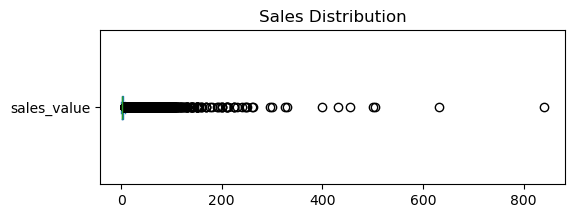

In [231]:
# sales statistics
print(transactions['sales_value'].describe())

# plot the sales_value distribution in box-plot
transactions['sales_value'].plot.box(vert=False, title = "Sales Distribution",figsize=(6,2));

#### Total Quantity

In [212]:
# Total quantity Sold
transactions['quantity'].sum()

216713611

#### Quantity Statistics & Distribution

count    2.146311e+06
mean     1.009703e+02
std      1.152364e+03
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      8.963800e+04
Name: quantity, dtype: float64


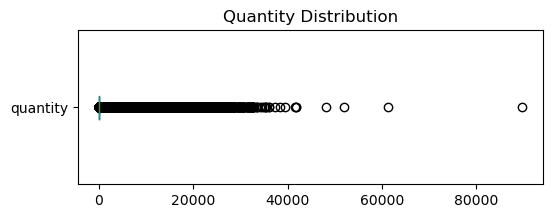

In [230]:
print(transactions['quantity'].describe())
transactions['quantity'].plot.box(vert=False, title = "Quantity Distribution",figsize=(6,2));

#### Total Discount

In [221]:
# Total Discount

transactions['total_discount'].sum()

-1178658.0799999998

#### Total Discount Statistics & Distribution

count    2.146311e+06
mean    -5.491553e-01
std      1.257714e+00
min     -1.300200e+02
25%     -6.900000e-01
50%     -5.000000e-02
75%      0.000000e+00
max      3.990000e+00
Name: total_discount, dtype: float64


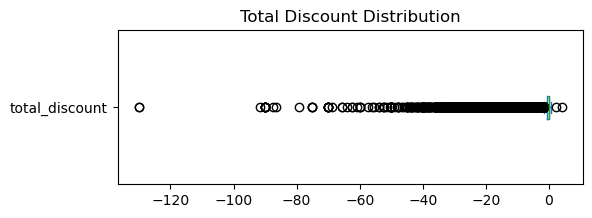

In [229]:
print(transactions['total_discount'].describe())
transactions['total_discount'].plot.box(vert=False, title = "Total Discount Distribution",figsize=(6,2));

#### Overall Percent Discount

In [206]:
# Overall Percent Discount

transactions['total_discount'].sum() / transactions['sales_value'].sum()

-0.17680990848745495

The value shows steep discount, however, since this is a discount retailer, it is not too suprising!

#### Discount Percentage Statistics & Distribution

count    2.146311e+06
mean     2.073245e-01
std      2.910501e-01
min      0.000000e+00
25%      0.000000e+00
50%      3.200000e-02
75%      3.317000e-01
max      1.000000e+00
Name: percentage_discount, dtype: float64


<Axes: ylabel='Frequency'>

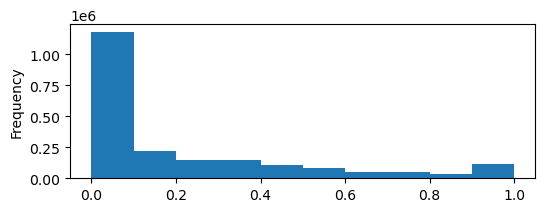

In [228]:
print(transactions['percentage_discount'].describe())
transactions['percentage_discount'].plot.hist( figsize=(6,2))

Findings:

The majority of the item comes with less than 20% discount


Checking to see which prodduct is associated the largest quantity

In [232]:
# Use to grab row with max value - discount rate is lower than average

transactions.loc[transactions["quantity"].argmax()]

household_key          6.300000e+02
basket_id              3.474915e+10
day                   -9.000000e+00
product_id             6.534178e+06
quantity               8.963800e+04
sales_value            2.500000e+02
store_id               3.840000e+02
week_no                7.300000e+01
total_discount        -1.345000e+01
percentage_discount    5.380000e-02
Name: 1442095, dtype: float64

Findings:

The product id is 6534178, and it comes with 5% discount rate, which is nice as the retailer does not lose much for this high vlume product

#### Average Sales Value per Basket

In [77]:
# Sales value per transaction/basket

transactions['sales_value'].sum() / transactions['basket_id'].nunique()

28.61797938516092

#### Average Sales Value per Household

In [31]:
# Sales value per household

transactions['sales_value'].sum() / transactions['household_key'].nunique()

3175.9140066698424

## Household Analysis

I will:

* Plot the distribution of total sales value purchased at the household level.
* Plot the purchasing frequency at the household level.

and find:

* What were the top 10 households by quantity purchased?
* What were the top 10 households by sales value?
* Plot the total sales value for our top 10 households by value, ordered from highest to lowest.

##### Sales Distribution

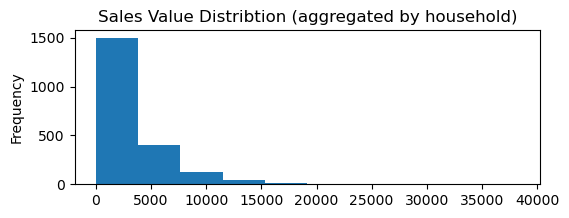

In [169]:
(transactions
 .groupby("household_key")
 .agg({'sales_value': 'sum'})
 .plot.hist(title="Sales Value Distribtion (aggregated by household)",legend=False,figsize=(6,2)));

#### Household Frequency

In [170]:
customer_frequency = transactions.groupby('household_key', as_index=False).agg(frequency=('basket_id', 'nunique'))#.reset_index()

Axes(0.125,0.11;0.775x0.77)


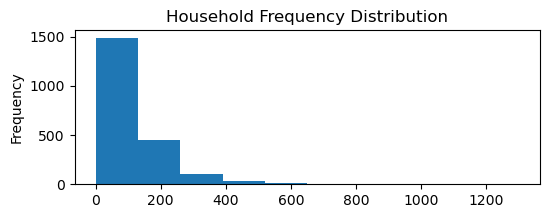

In [171]:
print(customer_frequency["frequency"].plot.hist(title="Household Frequency Distribution",figsize=(6,2)));

Axes(0.125,0.11;0.775x0.77)


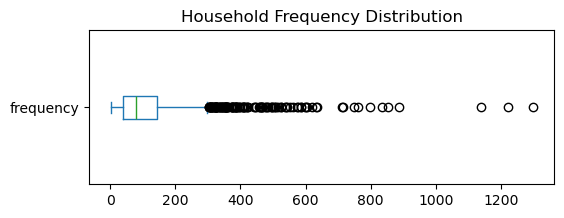

In [172]:
print(customer_frequency["frequency"].plot.box(title="Household Frequency Distribution",vert=False,figsize=(6,2)));

#### Top 20 Households by Value

In [192]:

top20_household_by_value = (transactions
                             .groupby("household_key")
                             .agg({'sales_value': 'sum'})
                             .sort_values("sales_value", ascending=False)
                             .iloc[:20])
top20_household_by_value

,sales_value
household_key,
1023,38319.789062
1609,27859.679688
1453,21661.289062
1430,20352.990234
718,19299.859375
707,19194.419922
1653,19153.750000
1111,18894.720703
982,18790.339844


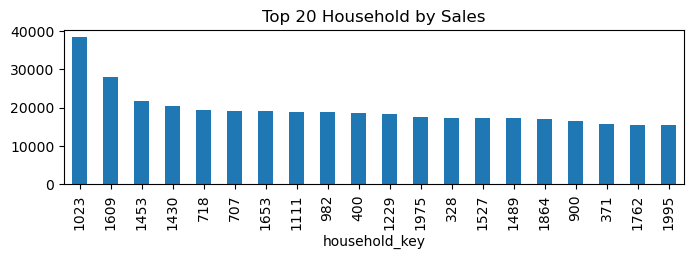

In [193]:
top20_household_by_value.plot.bar(title="Top 20 Household by Sales",legend=False,figsize=(8,2));

#### Top 20 Households by Quantity

In [194]:
top20_household_by_quantity = (transactions
                .groupby("household_key")
                 .agg({"quantity": "sum"})
                 .sort_values("quantity", ascending=False)
                 .iloc[:20])

top20_household_by_quantity

,quantity
household_key,
1023,4479917
755,3141769
1609,2146715
13,1863829
1430,1741892
1527,1734632
1762,1669880
707,1640193
1029,1496204


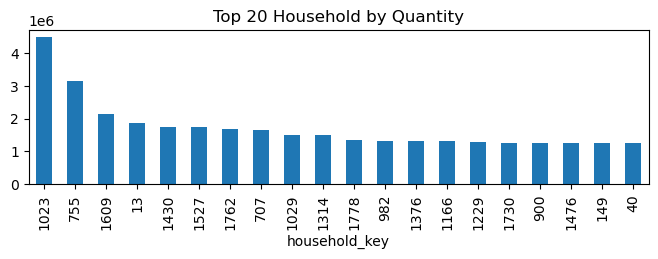

In [195]:
top20_household_by_quantity.plot.bar(title="Top 20 Household by Quantity",legend=False,figsize=(8,2));

#### Identifying super-households (are in both top 20 by Sales and top 20 by quantity).

In [196]:
# merge the two DataFrames on household_key to find common customers
super_customers = pd.merge(top20_household_by_value.reset_index(), 
                           top20_household_by_quantity.reset_index(), 
                           on="household_key")

super_customers

,household_key,sales_value,quantity
0,1023,38319.789062,4479917
1,1609,27859.679688,2146715
2,1430,20352.990234,1741892
3,707,19194.419922,1640193
4,982,18790.339844,1329976
5,1229,18304.310547,1295539
6,1527,17295.179688,1734632
7,900,16450.529297,1264243
8,1762,15360.139648,1669880


## Product Analysis

* Which products had the most sales by sales_value? Plot  a horizontal bar chart.
* Did the top 10 selling items have a higher than average discount rate?
* What was the most common `product_id` among rows with the households in our top 10 households by sales value?
* Look up the names of the  top 10 products by sales in the `products.csv` dataset.
* Look up the product name of the item that had the highest quantity sold in a single row.

<Axes: ylabel='Frequency'>

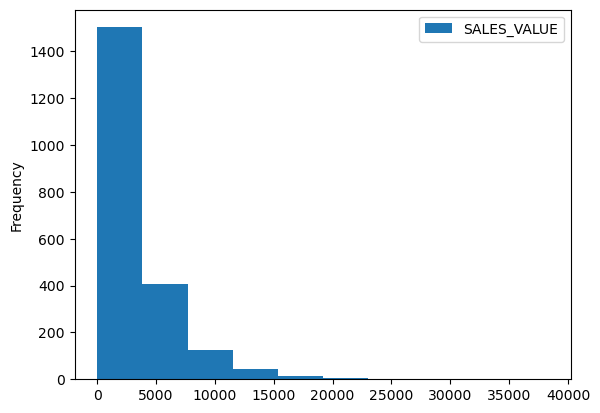

In [32]:
# plot distribution of households by total sales value
# First groupby household and calculate sum of sales
# then plot with a histogram

(transactions
 .groupby("household_key")
 .agg({'sales_value': 'sum'})
 .plot.hist())

# Final Project

Ok, so today we'll be working with the transactions, product, and hh_demographic tables in the project_data folder.

* First, read in the transactions data.

* Read in the only columns `household_key`, `basket_id`, `store_id`, `day`, `quantity`, and `sales_value`.

* Convert `day`, `quantity`, and `store_id` to the smallest appropriate integer types.


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Use the following snippet to create a Date Column.

transactions = (
    transactions
    .assign(date = (pd.to_datetime("2016", format='%Y') 
            + pd.to_timedelta(transactions["day"].sub(1).astype(str) + " days"))
           )
    .drop(["day"], axis=1)
)

## TIME BASED ANALYSIS

* Plot the sum of sales by month. Are sales growing over time?
* Next, plot the same series after filtering down to dates April 2016 and October 2017.
* Then, plot the sum of monthly sales in 2016 vs the monthly sales 2017.
* Finally, plot total sales by day of week.

# DEMOGRAPHICS

* Read in the `hh_demographic.csv` file, but only the columns `AGE_DESC`, `INCOME_DESC`, `household_key`, and `HH_COMP_DESC`. Convert the appropriate columns to the category dtype.


* Then group the transactions table by household_id, and calculate the sum of SALES VALUE by household.


* Once you've done that, join the demographics DataFrame to the aggregated transactions table. Since we're interested in analyzing the demographic data we have, make sure not to include rows from transactions that don't match.


* Plot the sum of sales by age_desc and income_desc (in separate charts).


* Then, create a pivot table of the mean household sales by `AGE_DESC` and `HH_COMP_DESC`. Which of our demographics have the highest average sales?


# PRODUCT DEMOGRAPHICS

* Read in the product csv file.

* Only read in product_id and department from product (consider converting columns).

* Join the product DataFrame to transactions and demographics tables, performing an inner join when joining both tables.

* Finally, pivot the fully joined dataframe by AGE_DESC and DEPARTMENT, calculating the sum of sales. Which category does our youngest demographic perform well in?



# EXPORT

Finally, export your pivot table to an excel file. Make sure to provide a sheet name.